In [7]:
!pip install pandas numpy scikit-learn xgboost lightgbm catboost shap lime matplotlib

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [9]:
# 데이터 불러오기
df = pd.read_csv("C:/Users/xison/Desktop/기계학습_팀플_데이터셋/201807_회윈_통합_노말.csv")

In [10]:
print(df.columns.tolist())

['남녀구분코드', '연령', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '카드신청건수', '최종카드발급경과월', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV약정청구율', 'RV최소결제비율', '자발한도감액횟수_R12M', 

In [11]:
# RV전환가능여부가 1인 샘플만 필터링
df = df[df["RV전환가능여부"] == 1].copy()

In [12]:
# 타겟 및 피처 설정
target = 'CA한도금액'
selected_features = [
        '카드이용한도금액','카드이용한도금액_B1M','회원여부_이용가능_CA','카드이용한도금액_B2M',
        '회원여부_이용가능','강제한도감액횟수_R12M','소지카드수_이용가능_신용','강제한도감액후경과월',
        '상향가능한도금액','RV현금서비스이자율_할인전'
]
X = df[selected_features]
y = df[target]

100%|===================| 174350/174603 [03:07<00:00]        

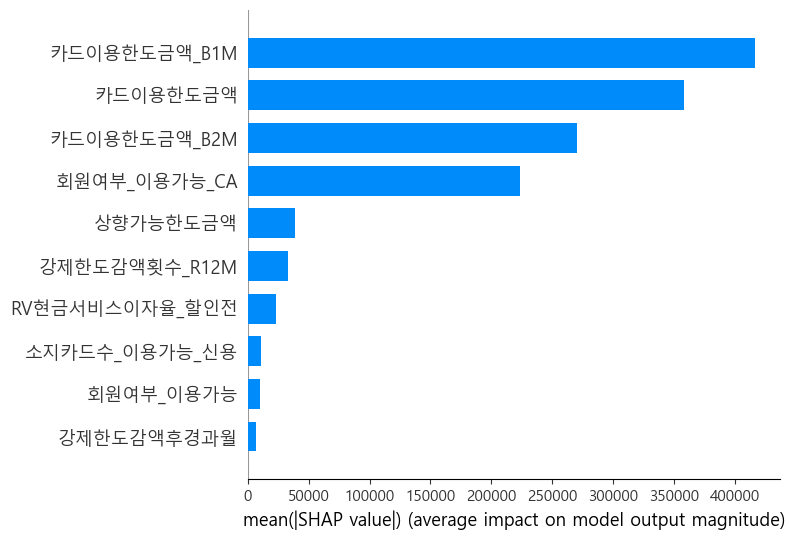

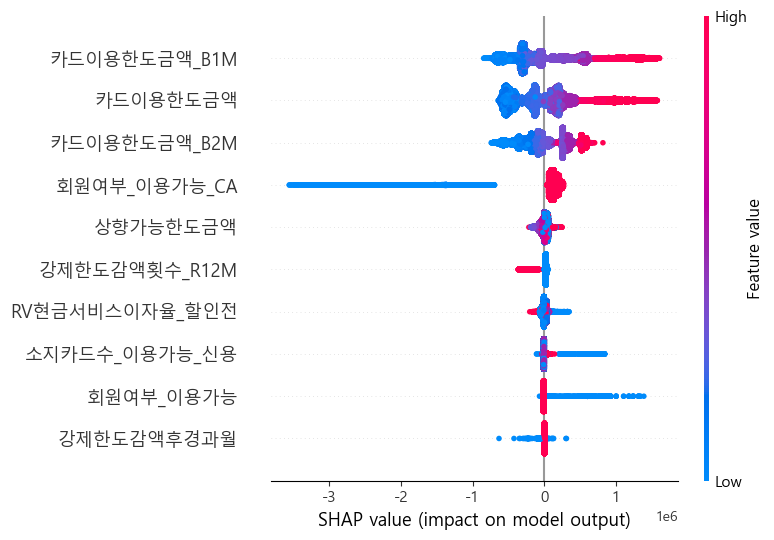

In [13]:
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import platform  # Importing platform module

# ✅ 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux or Colab
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GPU 사용 안하도록 XGBoost 설정
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, tree_method='hist', predictor='cpu_predictor', random_state=42)
model.fit(X_train, y_train)

# TreeExplainer 사용
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)  # ✅ additivity check 비활성화

# Summary plot - bar
shap.summary_plot(shap_values, X_test, plot_type="bar")
# Summary plot - dot
shap.summary_plot(shap_values, X_test)

## 피처엔지니어링

In [14]:
import numpy as np

# 복사본 생성
X = X.copy()

# ✅ 1. 한도 변화율
X["한도_증감율"] = (
    (X["카드이용한도금액"] - ((X["카드이용한도금액_B1M"] + X["카드이용한도금액_B2M"]) / 2)) /
    (((X["카드이용한도금액_B1M"] + X["카드이용한도금액_B2M"]) / 2) + 1)
)

# ✅ 2. 평균 한도 (B1M, B2M, 현재)
X["카드이용한도_평균"] = (
    X["카드이용한도금액"] + X["카드이용한도금액_B1M"] + X["카드이용한도금액_B2M"]
) / 3

# ✅ 3. 상향 가능 여부 (이진화)
X["상향가능여부"] = (X["상향가능한도금액"] > 0).astype(int)

# ✅ 4. 이자율 x 한도 상호작용 → 로그 변환
X["이자율x한도"] = X["RV현금서비스이자율_할인전"] * X["카드이용한도금액"]
X["이자율x한도"] = X["이자율x한도"].fillna(0).clip(upper=10_000_000).apply(np.log1p)

# ✅ 5. 감액 강도: 감액횟수 / (후경과월 + 1)
X["감액강도"] = X["강제한도감액횟수_R12M"] / (X["강제한도감액후경과월"] + 1)

# ✅ 6. 결측치 처리
X = X.fillna(0)

drop_features = [
    "상향가능한도금액", "강제한도감액후경과월", "강제한도감액횟수_R12M"
]
X.drop(columns=drop_features, inplace=True)

### 데이터 분할

In [15]:
from sklearn.model_selection import train_test_split

# 1단계: 전체 데이터에서 10%를 테스트셋으로 분할
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 2단계: 남은 90%에서 7:2 비율로 train/validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42
)

# 최종 확인
print(f"Train size: {X_train.shape[0]} rows")
print(f"Validation size: {X_val.shape[0]} rows")
print(f"Test size: {X_test.shape[0]} rows")

Train size: 611108 rows
Validation size: 174603 rows
Test size: 87302 rows


### 그냥 모델

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pickle
import os

# 🔧 피클 저장 디렉토리 생성
pickle_dir = "노말데이터_모델별피클"
os.makedirs(pickle_dir, exist_ok=True)

# 모델 정의
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

results = {}

# 학습 및 평가 + 모델 저장
for name, model in models.items():
    print(f"🔄 Training model: {name}")
    model.fit(X_train, y_train)

    # ▶ 피클로 저장 (모델별피클 디렉토리 내부)
    filename = os.path.join(pickle_dir, f"model_{name}.pkl")
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f" 모델 저장 완: {filename}")

    # ▶ Train 성능
    train_preds = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)

    # ▶ Test 성능
    test_preds = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_preds)
    test_r2 = r2_score(y_test, test_preds)

    # ▶ 결과 저장
    results[name] = {
        "Train MSE": train_mse,
        "Train R2": train_r2,
        "Test MSE": test_mse,
        "Test R2": test_r2,
    }

# 결과 테이블 출력
results_df = pd.DataFrame(results).T
print("📊 모델별 Train & Test 성능 비교")
display(results_df)

🔄 Training model: RandomForest
 모델 저장 완: 노말데이터_모델별피클\model_RandomForest.pkl
🔄 Training model: XGBoost
 모델 저장 완: 노말데이터_모델별피클\model_XGBoost.pkl
🔄 Training model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 611108, number of used features: 12
[LightGBM] [Info] Start training from score 2224731.302102
 모델 저장 완: 노말데이터_모델별피클\model_LightGBM.pkl
🔄 Training model: CatBoost
 모델 저장 완: 노말데이터_모델별피클\model_CatBoost.pkl
📊 모델별 Train & Test 성능 비교


,Train MSE,Train R2,Test MSE,Test R2
RandomForest,8.230416e+09,0.996148,5.831111e+10,0.972734
XGBoost,5.408819e+10,0.974687,5.585179e+10,0.973884
LightGBM,5.668173e+10,0.973473,5.681690e+10,0.973433
CatBoost,5.441138e+10,0.974536,5.551451e+10,0.974042


### 그냥 모델 시각화

In [17]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# ✅ 한글 폰트 설정 (Windows/Mac/Linux 공용)
if os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ✅ 저장 디렉토리
output_dir = "노말데이터_모델별성능시각화"
os.makedirs(output_dir, exist_ok=True)

# ✅ CatBoost 모델만 실행
name = "CatBoost"
model = models["CatBoost"]

print(f"\n📊 SHAP Feature Importance for {name}")

try:
    # Tree SHAP 사용
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # SHAP 바그래프
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"SHAP Summary - {name}")
    plt.tight_layout()
    shap_path = os.path.join(output_dir, f"shap_summary_{name}.png")
    plt.savefig(shap_path, dpi=300)
    plt.close()
    print(f"✅ SHAP 저장 완료: {shap_path}")
except Exception as e:
    print(f"❌ SHAP 실패 ({name}): {e}")

print(f"\n🔍 LIME Explanation for {name}")

try:
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X.columns.tolist(),
        mode="regression"
    )
    lime_exp = lime_explainer.explain_instance(
        X_test.values[0],
        model.predict
    )

    # 시각화 저장
    fig = lime_exp.as_pyplot_figure()
    lime_path = os.path.join(output_dir, f"lime_summary_{name}.png")
    fig.savefig(lime_path, dpi=300)
    plt.close(fig)
    print(f"✅ LIME 저장 완료: {lime_path}")
except Exception as e:
    print(f"❌ LIME 실패 ({name}): {e}")


📊 SHAP Feature Importance for CatBoost
✅ SHAP 저장 완료: 노말데이터_모델별성능시각화\shap_summary_CatBoost.png

🔍 LIME Explanation for CatBoost
✅ LIME 저장 완료: 노말데이터_모델별성능시각화\lime_summary_CatBoost.png


### 하이어파라미터튜닝

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
import os

# 저장 디렉토리
pickle_dir = "노말데이터_튜닝된모델별피클"
os.makedirs(pickle_dir, exist_ok=True)

# 튜닝할 모델과 파라미터 그리드 정의
model_grids = {
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.01]
        }
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [-1, 5, 10],
            'learning_rate': [0.1, 0.01]
        }
    ),
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_state=42),
        {
            'depth': [4, 6, 8],
            'learning_rate': [0.1, 0.01],
            'iterations': [100, 200]
        }
    )
}

results = {}
best_params = {}

# 튜닝 + 학습 + 평가 + 저장
for name, (model, param_grid) in model_grids.items():
    print(f"\n🔄 GridSearchCV tuning: {name}")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params[name] = grid.best_params_

    # 저장
    filename = os.path.join(pickle_dir, f"model_{name}_tuned.pkl")
    with open(filename, "wb") as f:
        pickle.dump(best_model, f)
    print(f"✅ 튜닝된 모델 저장 완료: {filename}")

    # 평가
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)

    results[name] = {
        "Train MSE": mean_squared_error(y_train, train_preds),
        "Train R2": r2_score(y_train, train_preds),
        "Test MSE": mean_squared_error(y_test, test_preds),
        "Test R2": r2_score(y_test, test_preds),
    }

# 결과 테이블 출력
results_df = pd.DataFrame(results).T
print("📊 튜닝된 모델 성능 비교")
display(results_df)

# 최적 하이퍼파라미터 출력
print("🔧 최적 하이퍼파라미터")
for name, params in best_params.items():
    print(f"{name}: {params}")


🔄 GridSearchCV tuning: RandomForest
✅ 튜닝된 모델 저장 완료: 노말데이터_튜닝된모델별피클\model_RandomForest_tuned.pkl

🔄 GridSearchCV tuning: XGBoost
✅ 튜닝된 모델 저장 완료: 노말데이터_튜닝된모델별피클\model_XGBoost_tuned.pkl

🔄 GridSearchCV tuning: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 611108, number of used features: 12
[LightGBM] [Info] Start training from score 2224731.302102
✅ 튜닝된 모델 저장 완료: 노말데이터_튜닝된모델별피클\model_LightGBM_tuned.pkl

🔄 GridSearchCV tuning: CatBoost
✅ 튜닝된 모델 저장 완료: 노말데이터_튜닝된모델별피클\model_CatBoost_tuned.pkl
📊 튜닝된 모델 성능 비교


,Train MSE,Train R2,Test MSE,Test R2
RandomForest,5.679582e+10,0.973420,5.800082e+10,0.972879
XGBoost,5.461889e+10,0.974439,5.577675e+10,0.973919
LightGBM,5.544701e+10,0.974051,5.601085e+10,0.973810
CatBoost,5.671121e+10,0.973460,5.690886e+10,0.973390


🔧 최적 하이퍼파라미터
RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}
CatBoost: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}


### 하이어파라미터튜닝시각화

In [20]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

from sklearn.ensemble import RandomForestRegressor  # 필요 시 추가

# 🔠 한글 폰트 설정 (운영체제별 분기)
if os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')  # Windows
else:
    plt.rc('font', family='AppleGothic')   # macOS / Linux
plt.rcParams['axes.unicode_minus'] = False

# 📁 결과 저장 디렉토리 설정
output_dir = "RandomForest_해석시각화"
os.makedirs(output_dir, exist_ok=True)

# 🔍 모델 불러오기 (예: 튜닝된 RandomForest)
rf_model = tuned_models["RandomForest"]  # 또는 직접 정의된 모델 사용

# ✅ SHAP 시각화
print("\n📊 SHAP Feature Importance for RandomForest")
try:
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test)

    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title("SHAP Summary - RandomForest")
    plt.tight_layout()
    shap_path = os.path.join(output_dir, "shap_summary_RandomForest.png")
    plt.savefig(shap_path, dpi=300)
    plt.close()
    print(f"✅ SHAP 저장 완료: {shap_path}")
except Exception as e:
    print(f"❌ SHAP 실패: {e}")

# ✅ LIME 시각화
print("🔍 LIME Explanation for RandomForest")
try:
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X.columns.tolist(),
        mode="regression"
    )
    lime_exp = lime_explainer.explain_instance(
        X_test.values[0],  # 샘플 하나
        rf_model.predict
    )

    fig = lime_exp.as_pyplot_figure()
    lime_path = os.path.join(output_dir, "lime_summary_RandomForest.png")
    fig.savefig(lime_path, dpi=300)
    plt.close(fig)
    print(f"✅ LIME 저장 완료: {lime_path}")
except Exception as e:
    print(f"❌ LIME 실패: {e}")

NameError: name 'tuned_models' is not defined

### 교차 검증

🔁 튜닝된 모델들에 대해 Validation 기반 교차검증 (5-Fold) 시작

📌 RandomForest
  ✅ R2: 0.9727 ± 0.0002
  ✅ MSE: 58244083999.2104 ± 398666287.4509
  ✅ MAE: 177392.6671 ± 610.3591
  ✅ RMSE: 241336.6952 ± 826.7559

📌 XGBoost
  ✅ R2: 0.9735 ± 0.0002
  ✅ MSE: 56543434395.8687 ± 570183395.6980
  ✅ MAE: 175238.6272 ± 749.7759
  ✅ RMSE: 237785.6042 ± 1200.3545

📌 LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 139682, number of used features: 12
[LightGBM] [Info] Start training from score 2222776.227424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

,R2 Mean,R2 Std,MSE Mean,MSE Std,MAE Mean,MAE Std,RMSE Mean,RMSE Std
RandomForest,0.972691,0.000222,5.824408e+10,3.986663e+08,177392.667133,610.359116,241336.695249,826.755935
XGBoost,0.973489,0.000177,5.654343e+10,5.701834e+08,175238.627175,749.775866,237785.604158,1200.354515
LightGBM,0.973354,0.000174,5.683081e+10,5.531018e+08,175711.529787,757.801587,238389.294155,1161.718939
CatBoost,0.973159,0.000230,5.724866e+10,6.993237e+08,176751.449536,935.930969,239262.449237,1463.597112


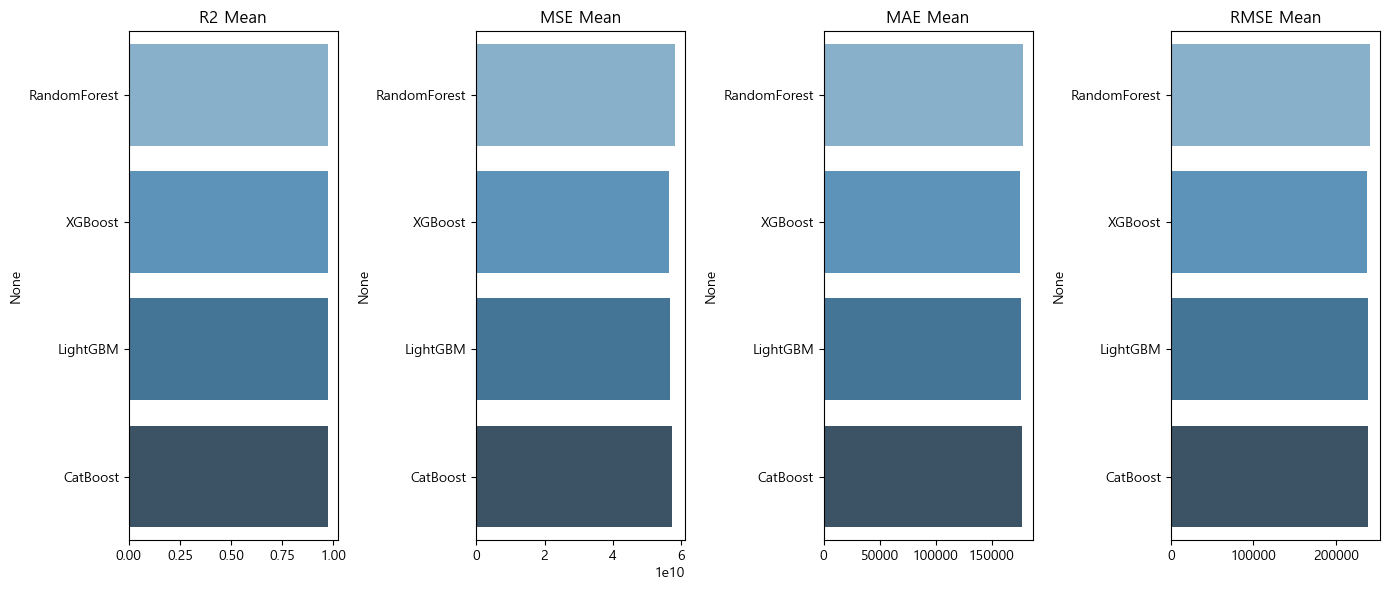


📂 시각화 저장 완료: 노말데이터_튜닝된모델_교차검증시각화\교차검증_성능비교.png
📂 성능표 저장 완료: 노말데이터_튜닝된모델_교차검증시각화\교차검증_성능비교표.csv


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# 💾 튜닝된 모델 저장 디렉토리
pickle_dir = "노말데이터_튜닝된모델별피클"

# 시각화 결과 저장 디렉토리
vis_dir = "노말데이터_튜닝된모델_교차검증시각화"
os.makedirs(vis_dir, exist_ok=True)

# 결과 저장용 딕셔너리
cv_results_all = {}

# 사용할 지표
scoring_metrics = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'  # 일부 sklearn 버전에서만 작동
}

print("🔁 튜닝된 모델들에 대해 Validation 기반 교차검증 (5-Fold) 시작\n")

# 각 모델에 대해 반복
for name in model_grids.keys():
    print(f"📌 {name}")
    filename = os.path.join(pickle_dir, f"model_{name}_tuned.pkl")
    with open(filename, "rb") as f:
        model = pickle.load(f)

    model_results = {}
    
    for metric_name, scoring in scoring_metrics.items():
        try:
            scores = cross_val_score(model, X_val, y_val, cv=5, scoring=scoring)
            if "neg_" in scoring:
                scores = -scores
            model_results[f"{metric_name} Mean"] = np.mean(scores)
            model_results[f"{metric_name} Std"] = np.std(scores)
            print(f"  ✅ {metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
        except Exception as e:
            model_results[f"{metric_name} Mean"] = None
            model_results[f"{metric_name} Std"] = None
            print(f"  ❌ {metric_name} 실패: {e}")
    
    cv_results_all[name] = model_results
    print()

# 📊 결과 DataFrame 정리
cv_results_df = pd.DataFrame(cv_results_all).T
print("📊 교차검증 종합 결과 (Validation 기준)")
display(cv_results_df)

# 📈 시각화
plt.figure(figsize=(14, 6))
metrics_to_plot = ['R2 Mean', 'MSE Mean', 'MAE Mean', 'RMSE Mean']
for i, metric in enumerate(metrics_to_plot, 1):
    if metric in cv_results_df.columns:
        plt.subplot(1, 4, i)
        sns.barplot(
            y=cv_results_df.index,
            x=cv_results_df[metric],
            palette='Blues_d'
        )
        plt.title(metric)
        plt.xlabel('')
        plt.tight_layout()

# 저장
plot_path = os.path.join(vis_dir, "교차검증_성능비교.png")
plt.savefig(plot_path, dpi=300)
plt.show()

# 📄 CSV 저장
csv_path = os.path.join(vis_dir, "교차검증_성능비교표.csv")
cv_results_df.to_csv(csv_path)

print(f"\n📂 시각화 저장 완료: {plot_path}")
print(f"📂 성능표 저장 완료: {csv_path}")